This Notebook provides a minimal example for using LFP to train a simple LeNet on MNIST.

For more complex examples, refer to the experiment notebooks in ./nbs

### Imports

In [1]:
import os
import joblib
import random

import numpy as np
import torch
import torch.nn as tnn
import torcheval.metrics
import torchvision.datasets as tvisiondata
import torchvision.transforms as T
from tqdm import tqdm

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from lfprop.propagation import (
    propagator_lxt as propagator,
)  # LFP propagator. Alternatively, use propagator_zennit
from lfprop.rewards import reward_functions as rewards  # Reward Functions
from lfprop.rewards import rewards as loss_fns

/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters

In [2]:
model_name = "mlp" #lenet
optimizer_name = "sgd"
savepath = f"/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f52/reward-backprop/resubmission-1-experiments/test-regression/{model_name}-{optimizer_name}"
os.makedirs(savepath, exist_ok=True)

input_size = 8
lr = 0.005
batch_size = 128
epochs = 100
momentum = 0.9

seed = 0

def set_random_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Dataset

In [3]:
class PrepareData(torch.utils.data.Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].type(torch.float32), self.y[idx].type(torch.float32)

X, y = fetch_california_housing(return_X_y=True)

# create train and test indices
train, test = train_test_split(list(range(X.shape[0])), test_size=.3)

ds = PrepareData(X, y=y, scale_X=True)

training_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                       sampler=torch.utils.data.SubsetRandomSampler(train))
test_loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                      sampler=torch.utils.data.SubsetRandomSampler(test))

### Load Model

In [4]:
class RegressionModel(torch.nn.Module):

    def __init__(self, input_size, activation=tnn.ReLU):
        super(RegressionModel, self).__init__()
        self.features = tnn.Sequential(
            torch.nn.Linear(in_features=input_size, out_features=256),
            activation(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(in_features=256, out_features=128),
            activation(),
            torch.nn.Dropout(p=0.5),
        )
        self.last = torch.nn.Linear(in_features=128, out_features=1)

    def forward(self, X):

        X = self.features(X)
        X = self.last(X)

        return X

model = RegressionModel(input_size=input_size)
model.to(device)

RegressionModel(
  (features): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (last): Linear(in_features=128, out_features=1, bias=True)
)

### Set Up LFP

In [5]:
# Initialize the LFP Composite (cf. "composites" in zennit or lxt).
# This call is the same whether the lxt or zennit backend is used (propagator_lxt and propagator_zennit).
# Currently, only LFP-Epsilon is implemented. More composites may be added in the future.
propagation_composite = propagator.LFPEpsilonComposite()
#propagation_composite = propagator.LFPHebbianEpsilonComposite(use_oja=True)
#propagation_composite = propagator.LFPGammaComposite(gamma=0.0)

# Initialize the Reward Function.
class RegressionReward:
    def __init__(self, device, **kwargs):
        """
        Computes regression reward
        """
        self.device = device

    def __call__(self, logits, labels):
        """
        Computation
        :param logits:
        :param labels:
        :return:
        """

        # Compute reward
        #reward = labels.view_as(logits) # Note: this is required as we need the regression target for backpropagating in the last layer
        reward = (labels.view_as(logits) - logits)**3 * logits.sign()
        return reward
    
reward_func = RegressionReward(device)

# LFP writes its updates into the .grad attribute of the model parameters, and can thus utilize standard torch optimizers
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

### Set Up Simple Evaluation using torcheval

In [6]:
def eval_model(loader):
    """
    Evaluates the model on a single dataset
    """
    eval_metrics = {
        "reward": torcheval.metrics.Mean(device=device),
        "mse": torcheval.metrics.MeanSquaredError(device=device),
    }

    model.eval()

    # Iterate over Data Loader
    for index, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)

        with torch.no_grad():
            # Get model predictions
            outputs = model(inputs)

        with torch.set_grad_enabled(True):
            # Get rewards
            reward = reward_func(outputs, labels)

        for k, v in eval_metrics.items():
            if k == "reward":
                eval_metrics[k].update(reward)
            else:
                eval_metrics[k].update(outputs.view(labels.shape), labels)

    return_dict = {m: metric.compute().detach().cpu().numpy() for m, metric in eval_metrics.items()}

    # Return evaluation
    return return_dict

### Training Loop

In [7]:
def lfp_step(inputs, labels):
    """
    Performs a single training step using LFP. This is quite similar to a standard gradient descent training loop.
    """
    # Set Model to training mode
    model.train()

    with torch.enable_grad():
        # Zero Optimizer
        optimizer.zero_grad()

        # This applies LFP Hooks/Functions (which depends on whether lxt or zennit backend is used)
        with propagation_composite.context(model) as modified:


            inputs = inputs.detach().requires_grad_(True)
            outputs = modified(inputs)

            # Calculate reward
            # Do like this to avoid tensors being kept in memory
            reward = torch.from_numpy(reward_func(outputs, labels).detach().cpu().numpy()).to(device)

            # Calculate LFP and write into .feedback attribute of parameters
            torch.autograd.grad((outputs,), (inputs,), grad_outputs=(reward,), retain_graph=False)[0]

            # Write LFP Values into .grad attributes. Note the negative sign: LFP requires maximization instead of minimization like gradient descent
            for name, param in model.named_parameters():
                param.grad = -param.feedback

            # Update Clipping. Training may become unstable otherwise, especially in small models with large learning rates.
            # In larger models (e.g., VGG, ResNet), where smaller learning rates are generally utilized, not clipping updates may result in better performance.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0, 2.0)

            # Optimization step
            optimizer.step()

    # Set Model back to eval mode
    model.eval()


# Training Loop
result = {
    "mse_train": [],
    "mse_test": [],
    "reward_train": [],
    "reward_test": [],
}

# Evaluate and print performance after every epoch
eval_stats_train = eval_model(training_loader)
eval_stats_test = eval_model(test_loader)
print(
    "Init: (Train Reward) {:.2f}; (Train MSE) {:.2f}; (Val Reward) {:.2f}; (Val MSE) {:.2f}".format(
        float(np.mean(eval_stats_train["reward"])),
        float(eval_stats_train["mse"]),
        float(np.mean(eval_stats_test["reward"])),
        float(eval_stats_test["mse"]),
    )
)

result["mse_train"].append(float(np.mean(eval_stats_train["mse"])))
result["mse_test"].append(float(np.mean(eval_stats_test["mse"])))
result["reward_train"].append(float(np.mean(eval_stats_train["reward"])))
result["reward_test"].append(float(np.mean(eval_stats_test["reward"])))

for epoch in range(epochs):
    with tqdm(total=len(training_loader)) as pbar:
        # Iterate over Data Loader
        for index, (inputs, labels) in enumerate(training_loader):
            inputs = inputs.to(device)
            labels = torch.tensor(labels).to(device)

            # Perform Update Step
            lfp_step(inputs, labels)

            # Update Progress Bar
            pbar.update(1)

    # Evaluate and print performance after every epoch
    eval_stats_train = eval_model(training_loader)
    eval_stats_test = eval_model(test_loader)
    print(
        "Epoch {}/{}: (Train Reward) {:.2f}; (Train MSE) {:.2f}; (Val Reward) {:.2f}; (Val MSE) {:.2f}".format(
            epoch + 1,
            epochs,
            float(np.mean(eval_stats_train["reward"])),
            float(eval_stats_train["mse"]),
            float(np.mean(eval_stats_test["reward"])),
            float(eval_stats_test["mse"]),
        )
    )

    result["mse_train"].append(float(np.mean(eval_stats_train["mse"])))
    result["mse_test"].append(float(np.mean(eval_stats_test["mse"])))
    result["reward_train"].append(float(np.mean(eval_stats_train["reward"])))
    result["reward_test"].append(float(np.mean(eval_stats_test["reward"])))

/tmp/ipykernel_478847/2800525172.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Init: (Train Reward) -20.40; (Train MSE) 6.09; (Val Reward) -21.13; (Val MSE) 6.25


  0%|          | 0/113 [00:00<?, ?it/s]/tmp/ipykernel_478847/3228589649.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/lxt/core.py:362: UserWarning: This functionality is not yet fully tested. Please check the model after removing the composite.
  warn(
100%|██████████| 113/113 [00:01<00:00, 101.13it/s]


Epoch 1/100: (Train Reward) 0.50; (Train MSE) 0.65; (Val Reward) 0.31; (Val MSE) 0.69


100%|██████████| 113/113 [00:01<00:00, 92.45it/s] 


Epoch 2/100: (Train Reward) 0.08; (Train MSE) 0.63; (Val Reward) 0.12; (Val MSE) 0.64


100%|██████████| 113/113 [00:01<00:00, 106.86it/s]


Epoch 3/100: (Train Reward) 0.07; (Train MSE) 0.54; (Val Reward) 0.13; (Val MSE) 0.55


100%|██████████| 113/113 [00:01<00:00, 109.89it/s]


Epoch 4/100: (Train Reward) -0.10; (Train MSE) 0.56; (Val Reward) -0.05; (Val MSE) 0.57


100%|██████████| 113/113 [00:00<00:00, 114.53it/s]


Epoch 5/100: (Train Reward) 0.26; (Train MSE) 0.45; (Val Reward) 0.30; (Val MSE) 0.46


100%|██████████| 113/113 [00:00<00:00, 114.02it/s]


Epoch 6/100: (Train Reward) 0.27; (Train MSE) 0.46; (Val Reward) 0.32; (Val MSE) 0.48


100%|██████████| 113/113 [00:01<00:00, 93.20it/s] 


Epoch 7/100: (Train Reward) 0.12; (Train MSE) 0.45; (Val Reward) 0.15; (Val MSE) 0.46


100%|██████████| 113/113 [00:01<00:00, 111.01it/s]


Epoch 8/100: (Train Reward) 0.01; (Train MSE) 0.47; (Val Reward) 0.05; (Val MSE) 0.48


100%|██████████| 113/113 [00:00<00:00, 117.84it/s]


Epoch 9/100: (Train Reward) 0.09; (Train MSE) 0.44; (Val Reward) 0.13; (Val MSE) 0.45


100%|██████████| 113/113 [00:00<00:00, 114.68it/s]


Epoch 10/100: (Train Reward) 0.08; (Train MSE) 0.43; (Val Reward) 0.10; (Val MSE) 0.44


100%|██████████| 113/113 [00:01<00:00, 110.30it/s]


Epoch 11/100: (Train Reward) 0.07; (Train MSE) 0.43; (Val Reward) 0.10; (Val MSE) 0.43


100%|██████████| 113/113 [00:01<00:00, 95.14it/s] 


Epoch 12/100: (Train Reward) 0.31; (Train MSE) 0.39; (Val Reward) 0.35; (Val MSE) 0.40


100%|██████████| 113/113 [00:00<00:00, 113.87it/s]


Epoch 13/100: (Train Reward) -0.06; (Train MSE) 0.47; (Val Reward) -0.03; (Val MSE) 0.48


100%|██████████| 113/113 [00:00<00:00, 113.96it/s]


Epoch 14/100: (Train Reward) 0.08; (Train MSE) 0.40; (Val Reward) 0.11; (Val MSE) 0.40


100%|██████████| 113/113 [00:00<00:00, 113.59it/s]


Epoch 15/100: (Train Reward) 0.12; (Train MSE) 0.39; (Val Reward) 0.14; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 115.60it/s]


Epoch 16/100: (Train Reward) 0.06; (Train MSE) 0.41; (Val Reward) 0.09; (Val MSE) 0.42


100%|██████████| 113/113 [00:00<00:00, 116.69it/s]


Epoch 17/100: (Train Reward) -0.11; (Train MSE) 0.46; (Val Reward) -0.08; (Val MSE) 0.46


100%|██████████| 113/113 [00:00<00:00, 116.48it/s]


Epoch 18/100: (Train Reward) 0.04; (Train MSE) 0.41; (Val Reward) 0.04; (Val MSE) 0.42


100%|██████████| 113/113 [00:00<00:00, 115.59it/s]


Epoch 19/100: (Train Reward) 0.10; (Train MSE) 0.39; (Val Reward) 0.10; (Val MSE) 0.41


100%|██████████| 113/113 [00:00<00:00, 115.08it/s]


Epoch 20/100: (Train Reward) 0.10; (Train MSE) 0.37; (Val Reward) 0.12; (Val MSE) 0.38


100%|██████████| 113/113 [00:00<00:00, 113.21it/s]


Epoch 21/100: (Train Reward) 0.11; (Train MSE) 0.39; (Val Reward) 0.13; (Val MSE) 0.40


100%|██████████| 113/113 [00:00<00:00, 114.34it/s]


Epoch 22/100: (Train Reward) 0.09; (Train MSE) 0.38; (Val Reward) 0.12; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 114.38it/s]


Epoch 23/100: (Train Reward) 0.05; (Train MSE) 0.40; (Val Reward) 0.07; (Val MSE) 0.41


100%|██████████| 113/113 [00:00<00:00, 114.47it/s]


Epoch 24/100: (Train Reward) 0.14; (Train MSE) 0.36; (Val Reward) 0.17; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 113.35it/s]


Epoch 25/100: (Train Reward) 0.11; (Train MSE) 0.35; (Val Reward) 0.15; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 114.57it/s]


Epoch 26/100: (Train Reward) 0.18; (Train MSE) 0.35; (Val Reward) 0.21; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 113.78it/s]


Epoch 27/100: (Train Reward) 0.20; (Train MSE) 0.34; (Val Reward) 0.22; (Val MSE) 0.36


100%|██████████| 113/113 [00:01<00:00, 95.72it/s] 


Epoch 28/100: (Train Reward) 0.13; (Train MSE) 0.36; (Val Reward) 0.15; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 113.23it/s]


Epoch 29/100: (Train Reward) 0.05; (Train MSE) 0.37; (Val Reward) 0.06; (Val MSE) 0.38


100%|██████████| 113/113 [00:00<00:00, 113.36it/s]


Epoch 30/100: (Train Reward) 0.06; (Train MSE) 0.36; (Val Reward) 0.08; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 116.79it/s]


Epoch 31/100: (Train Reward) 0.09; (Train MSE) 0.35; (Val Reward) 0.11; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 114.79it/s]


Epoch 32/100: (Train Reward) 0.07; (Train MSE) 0.35; (Val Reward) 0.09; (Val MSE) 0.37


100%|██████████| 113/113 [00:01<00:00, 102.66it/s]


Epoch 33/100: (Train Reward) 0.12; (Train MSE) 0.34; (Val Reward) 0.14; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 121.65it/s]


Epoch 34/100: (Train Reward) -0.08; (Train MSE) 0.41; (Val Reward) -0.06; (Val MSE) 0.42


100%|██████████| 113/113 [00:00<00:00, 118.08it/s]


Epoch 35/100: (Train Reward) -0.01; (Train MSE) 0.37; (Val Reward) 0.02; (Val MSE) 0.38


100%|██████████| 113/113 [00:00<00:00, 114.59it/s]


Epoch 36/100: (Train Reward) 0.12; (Train MSE) 0.34; (Val Reward) 0.14; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 113.28it/s]


Epoch 37/100: (Train Reward) 0.21; (Train MSE) 0.35; (Val Reward) 0.24; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 119.21it/s]


Epoch 38/100: (Train Reward) -0.03; (Train MSE) 0.37; (Val Reward) -0.04; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 117.36it/s]


Epoch 39/100: (Train Reward) 0.21; (Train MSE) 0.35; (Val Reward) 0.23; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 117.04it/s]


Epoch 40/100: (Train Reward) 0.18; (Train MSE) 0.33; (Val Reward) 0.21; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 113.77it/s]


Epoch 41/100: (Train Reward) 0.07; (Train MSE) 0.34; (Val Reward) 0.09; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 115.37it/s]


Epoch 42/100: (Train Reward) -0.02; (Train MSE) 0.39; (Val Reward) -0.01; (Val MSE) 0.40


100%|██████████| 113/113 [00:00<00:00, 117.94it/s]


Epoch 43/100: (Train Reward) 0.19; (Train MSE) 0.33; (Val Reward) 0.19; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 114.36it/s]


Epoch 44/100: (Train Reward) 0.04; (Train MSE) 0.36; (Val Reward) 0.00; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 114.79it/s]


Epoch 45/100: (Train Reward) 0.13; (Train MSE) 0.33; (Val Reward) 0.10; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 116.75it/s]


Epoch 46/100: (Train Reward) -0.16; (Train MSE) 0.44; (Val Reward) -0.20; (Val MSE) 0.45


100%|██████████| 113/113 [00:01<00:00, 111.55it/s]


Epoch 47/100: (Train Reward) -0.00; (Train MSE) 0.37; (Val Reward) -0.05; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 113.52it/s]


Epoch 48/100: (Train Reward) 0.05; (Train MSE) 0.37; (Val Reward) 0.01; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 113.39it/s]


Epoch 49/100: (Train Reward) 0.08; (Train MSE) 0.34; (Val Reward) 0.03; (Val MSE) 0.36


100%|██████████| 113/113 [00:01<00:00, 112.15it/s]


Epoch 50/100: (Train Reward) 0.11; (Train MSE) 0.32; (Val Reward) -0.10; (Val MSE) 0.36


100%|██████████| 113/113 [00:01<00:00, 110.85it/s]


Epoch 51/100: (Train Reward) 0.06; (Train MSE) 0.34; (Val Reward) -0.07; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 114.63it/s]


Epoch 52/100: (Train Reward) 0.07; (Train MSE) 0.35; (Val Reward) 0.06; (Val MSE) 0.37


100%|██████████| 113/113 [00:01<00:00, 111.12it/s]


Epoch 53/100: (Train Reward) 0.08; (Train MSE) 0.34; (Val Reward) 0.10; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 113.86it/s]


Epoch 54/100: (Train Reward) -0.02; (Train MSE) 0.37; (Val Reward) -0.00; (Val MSE) 0.38


100%|██████████| 113/113 [00:00<00:00, 113.83it/s]


Epoch 55/100: (Train Reward) 0.12; (Train MSE) 0.33; (Val Reward) 0.15; (Val MSE) 0.34


100%|██████████| 113/113 [00:01<00:00, 112.41it/s]


Epoch 56/100: (Train Reward) 0.18; (Train MSE) 0.32; (Val Reward) 0.19; (Val MSE) 0.34


100%|██████████| 113/113 [00:01<00:00, 112.79it/s]


Epoch 57/100: (Train Reward) -0.01; (Train MSE) 0.37; (Val Reward) -0.03; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 114.21it/s]


Epoch 58/100: (Train Reward) 0.00; (Train MSE) 0.36; (Val Reward) 0.02; (Val MSE) 0.37


100%|██████████| 113/113 [00:01<00:00, 94.62it/s] 


Epoch 59/100: (Train Reward) -0.01; (Train MSE) 0.37; (Val Reward) 0.02; (Val MSE) 0.38


100%|██████████| 113/113 [00:01<00:00, 112.29it/s]


Epoch 60/100: (Train Reward) 0.07; (Train MSE) 0.33; (Val Reward) 0.10; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 114.14it/s]


Epoch 61/100: (Train Reward) 0.18; (Train MSE) 0.32; (Val Reward) 0.20; (Val MSE) 0.34


100%|██████████| 113/113 [00:01<00:00, 110.51it/s]


Epoch 62/100: (Train Reward) 0.16; (Train MSE) 0.32; (Val Reward) 0.13; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 115.29it/s]


Epoch 63/100: (Train Reward) 0.07; (Train MSE) 0.36; (Val Reward) 0.04; (Val MSE) 0.38


100%|██████████| 113/113 [00:00<00:00, 116.50it/s]


Epoch 64/100: (Train Reward) -0.03; (Train MSE) 0.36; (Val Reward) -0.02; (Val MSE) 0.38


100%|██████████| 113/113 [00:00<00:00, 113.14it/s]


Epoch 65/100: (Train Reward) 0.06; (Train MSE) 0.34; (Val Reward) 0.07; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 131.93it/s]


Epoch 66/100: (Train Reward) 0.08; (Train MSE) 0.34; (Val Reward) 0.05; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 121.31it/s]


Epoch 67/100: (Train Reward) 0.12; (Train MSE) 0.32; (Val Reward) 0.14; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 128.37it/s]


Epoch 68/100: (Train Reward) -0.00; (Train MSE) 0.36; (Val Reward) 0.01; (Val MSE) 0.38


100%|██████████| 113/113 [00:00<00:00, 122.46it/s]


Epoch 69/100: (Train Reward) 0.15; (Train MSE) 0.33; (Val Reward) 0.13; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 118.48it/s]


Epoch 70/100: (Train Reward) 0.04; (Train MSE) 0.34; (Val Reward) -0.03; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 116.58it/s]


Epoch 71/100: (Train Reward) 0.13; (Train MSE) 0.32; (Val Reward) 0.10; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 116.91it/s]


Epoch 72/100: (Train Reward) 0.08; (Train MSE) 0.33; (Val Reward) 0.08; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 116.41it/s]


Epoch 73/100: (Train Reward) 0.07; (Train MSE) 0.32; (Val Reward) 0.08; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 116.69it/s]


Epoch 74/100: (Train Reward) 0.04; (Train MSE) 0.33; (Val Reward) 0.05; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 115.31it/s]


Epoch 75/100: (Train Reward) 0.03; (Train MSE) 0.34; (Val Reward) 0.06; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 113.15it/s]


Epoch 76/100: (Train Reward) -0.03; (Train MSE) 0.35; (Val Reward) -0.01; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 127.49it/s]


Epoch 77/100: (Train Reward) 0.02; (Train MSE) 0.34; (Val Reward) 0.04; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 115.27it/s]


Epoch 78/100: (Train Reward) -0.04; (Train MSE) 0.37; (Val Reward) -0.03; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 115.82it/s]


Epoch 79/100: (Train Reward) -0.03; (Train MSE) 0.36; (Val Reward) -0.02; (Val MSE) 0.38


100%|██████████| 113/113 [00:01<00:00, 93.81it/s] 


Epoch 80/100: (Train Reward) -0.05; (Train MSE) 0.37; (Val Reward) -0.05; (Val MSE) 0.39


100%|██████████| 113/113 [00:00<00:00, 119.82it/s]


Epoch 81/100: (Train Reward) 0.02; (Train MSE) 0.34; (Val Reward) -0.01; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 114.48it/s]


Epoch 82/100: (Train Reward) 0.09; (Train MSE) 0.33; (Val Reward) 0.10; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 115.05it/s]


Epoch 83/100: (Train Reward) 0.14; (Train MSE) 0.32; (Val Reward) 0.17; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 113.48it/s]


Epoch 84/100: (Train Reward) 0.13; (Train MSE) 0.31; (Val Reward) 0.16; (Val MSE) 0.33


100%|██████████| 113/113 [00:01<00:00, 112.78it/s]


Epoch 85/100: (Train Reward) 0.10; (Train MSE) 0.32; (Val Reward) 0.13; (Val MSE) 0.34


100%|██████████| 113/113 [00:01<00:00, 112.60it/s]


Epoch 86/100: (Train Reward) 0.11; (Train MSE) 0.33; (Val Reward) 0.14; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 113.06it/s]


Epoch 87/100: (Train Reward) 0.10; (Train MSE) 0.31; (Val Reward) 0.13; (Val MSE) 0.33


100%|██████████| 113/113 [00:00<00:00, 113.34it/s]


Epoch 88/100: (Train Reward) 0.04; (Train MSE) 0.33; (Val Reward) 0.04; (Val MSE) 0.35


100%|██████████| 113/113 [00:01<00:00, 112.30it/s]


Epoch 89/100: (Train Reward) 0.02; (Train MSE) 0.33; (Val Reward) 0.02; (Val MSE) 0.35


100%|██████████| 113/113 [00:01<00:00, 111.35it/s]


Epoch 90/100: (Train Reward) 0.03; (Train MSE) 0.34; (Val Reward) -0.02; (Val MSE) 0.37


100%|██████████| 113/113 [00:00<00:00, 114.22it/s]


Epoch 91/100: (Train Reward) 0.13; (Train MSE) 0.32; (Val Reward) 0.13; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 115.11it/s]


Epoch 92/100: (Train Reward) 0.05; (Train MSE) 0.35; (Val Reward) 0.01; (Val MSE) 0.37


100%|██████████| 113/113 [00:01<00:00, 111.18it/s]


Epoch 93/100: (Train Reward) 0.08; (Train MSE) 0.32; (Val Reward) 0.01; (Val MSE) 0.35


100%|██████████| 113/113 [00:00<00:00, 113.93it/s]


Epoch 94/100: (Train Reward) 0.04; (Train MSE) 0.34; (Val Reward) 0.03; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 114.19it/s]


Epoch 95/100: (Train Reward) 0.02; (Train MSE) 0.33; (Val Reward) -0.04; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 113.07it/s]


Epoch 96/100: (Train Reward) 0.09; (Train MSE) 0.33; (Val Reward) -0.01; (Val MSE) 0.36


100%|██████████| 113/113 [00:01<00:00, 110.28it/s]


Epoch 97/100: (Train Reward) 0.03; (Train MSE) 0.33; (Val Reward) -0.07; (Val MSE) 0.36


100%|██████████| 113/113 [00:00<00:00, 113.44it/s]


Epoch 98/100: (Train Reward) 0.01; (Train MSE) 0.35; (Val Reward) -0.10; (Val MSE) 0.38


100%|██████████| 113/113 [00:00<00:00, 114.85it/s]


Epoch 99/100: (Train Reward) 0.03; (Train MSE) 0.32; (Val Reward) -0.00; (Val MSE) 0.34


100%|██████████| 113/113 [00:00<00:00, 116.33it/s]


Epoch 100/100: (Train Reward) 0.14; (Train MSE) 0.31; (Val Reward) 0.16; (Val MSE) 0.33


### Plots

/tmp/ipykernel_478847/1206499034.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


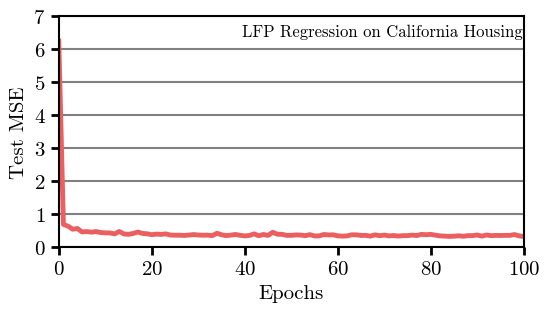

/tmp/ipykernel_478847/1206499034.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
/tmp/ipykernel_478847/1206499034.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


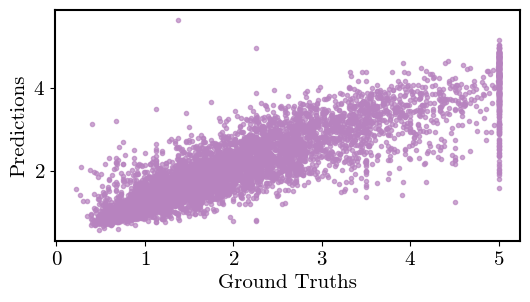

In [10]:
# Plot Settings
# Set font properties.
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.cm as cm
import copy
font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams['axes.linewidth'] = 1.5

def plot_accs(eval_stats, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    res = eval_stats["mse_test"]
    xaxis = np.arange(0, len(res))
    ax.plot(xaxis, res, color=palette[0], label=None, linewidth=3.5, alpha=1)
    ax.text(xaxis[-1]-0.2, 6.3, "LFP Regression on California Housing",
             horizontalalignment="right", verticalalignment="bottom", fontsize=12)

    linelocs = [0, 1, 2, 3, 4, 5, 6, 7]
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=xaxis[-1],
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel(f"Test MSE")
    ax.set_xlabel("Epochs")
    ax.set_ylim([0.0, 7.0])
    ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
    ax.set_xlim([0.0, xaxis[-1]])
    #ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 200])
    #ax.legend()
    plt.show()
    fig.savefig(fname)

def plot_scatter(model, loader, fname, colormap="Set1"):

    preds = []
    gts = []

    model.eval()
    # Iterate over Data Loader
    for index, (inputs, labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)

        with torch.no_grad():
            # Get model predictions
            outputs = model(inputs)

        preds.append(outputs.detach().cpu().numpy())
        gts.append(labels.detach().cpu().numpy())

    preds = np.concatenate(preds).flatten()
    gts = np.concatenate(gts).flatten()

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    ax.scatter(gts, preds, color=palette[3], alpha=0.7, marker=".")

    # linelocs = [0, 1, 2, 3, 4, 5, 6, 7]
    # ax.hlines(
    #     linelocs,
    #     xmin=-1,
    #     xmax=xaxis[-1],
    #     color=(0.5, 0.5, 0.5, 1),
    #     linewidth=1.5,
    #     zorder=0,
    # )

    ax.set_ylabel(f"Predictions")
    ax.set_xlabel("Ground Truths")
    #ax.set_ylim([0.0, 7.0])
    #ax.set_yticks([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
    #ax.set_xlim([0.0, xaxis[-1]])
    #ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    #ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 200])
    #ax.legend()
    plt.show()
    fig.savefig(fname)

plot_accs(result, os.path.join(savepath, "mse_test.svg"), colormap="Set1")
plot_scatter(model, test_loader, os.path.join(savepath, "scatter_test.svg"), colormap="Set1")